In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1]:
# =============================================================================
# 1. SETUP E IMPORTAÇÕES
# =============================================================================
import sys
import os
import json
import logging

# Adiciona a pasta raiz do projeto ao path para encontrar os módulos locais
project_path = os.path.abspath('..')
if project_path not in sys.path:
    sys.path.insert(0, project_path)
    print(f"Adicionado ao path do projeto: {project_path}")

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shap
import torch
import torch.nn as nn # Importa o nn para encontrar as funções de ativação

from data_loader import load_and_prepare_data
from models.mlp_space import MLPBlockSpace
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

Adicionado ao path do projeto: /home/iago/ProjetoFinal


/home/iago/ProjetoFinal/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Analisando a execução em: '../results/run_2025-06-17_14-02-22'
Configuração principal da execução carregada do log.
Melhor configuração de hiperparâmetros carregada do log.

Recarregando dados de referência para o dataset 'D3'...
Dados de referência carregados. Número de features: 10

Carregando modelo MLP...
Arquitetura do modelo recriada com a configuração correta.
Pesos do modelo carregados.
Modelo MLP e valores SHAP calculados.

Gerando gráficos SHAP...


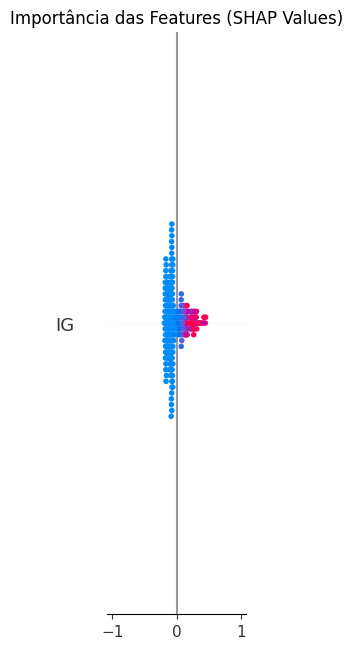

Gráfico 'shap_summary_bar.png' salvo em '../results/run_2025-06-17_14-02-22'


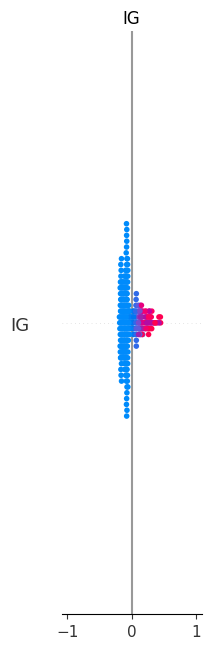

Gráfico 'shap_beeswarm.png' salvo em '../results/run_2025-06-17_14-02-22'


In [2]:
# =============================================================================
# 2. CONFIGURAÇÃO DA ANÁLISE
# =============================================================================
# !! IMPORTANTE: Altere esta variável para a pasta da execução que você quer analisar !!
RUN_PATH = "../results/run_2025-06-17_14-02-22" # Exemplo, use uma pasta que existe

print(f"Analisando a execução em: '{RUN_PATH}'")

# --- INÍCIO DA CORREÇÃO: LER A CONFIGURAÇÃO DO LOG ---
# Esta é a mudança principal: vamos carregar a configuração usada no experimento
# diretamente do arquivo de log, em vez de usar o config.py atual.
log_file = os.path.join(RUN_PATH, "run_log.jsonl")
run_config = None
best_config_from_log = None

try:
    with open(log_file, 'r') as f:
        for line in f:
            log_entry = json.loads(line)
            json_fields = log_entry.get("json_fields", {})
            
            # Captura a configuração inicial do run
            if "model_to_optimize" in json_fields and run_config is None:
                run_config = json_fields
                print("Configuração principal da execução carregada do log.")

            # Captura a melhor configuração encontrada pelo GA
            if "best_config_found" in json_fields:
                best_config_from_log = json_fields["best_config_found"]
                print("Melhor configuração de hiperparâmetros carregada do log.")

    if not run_config or not best_config_from_log:
        raise ValueError("Não foi possível encontrar as configurações necessárias no arquivo de log.")

except Exception as e:
    print(f"ERRO ao ler o arquivo de log '{log_file}': {e}")
    sys.exit() # Interrompe a execução se não conseguir ler o log

MODEL_TYPE = run_config['model_to_optimize']
DATASET_USED = run_config['dataset']
SEED_USED = run_config['seed']

# --- FIM DA CORREÇÃO ---


# =============================================================================
# 3. CARREGAMENTO DOS DADOS DE REFERÊNCIA
# =============================================================================
print(f"\nRecarregando dados de referência para o dataset '{DATASET_USED}'...")
csv_full_path = os.path.join(project_path, f"data/12_2_3-Jose_Gustavo_2008.xlsx")
Xdf, y = load_and_prepare_data(csv_full_path, DATASET_USED)

X_dev, _, _, _ = train_test_split(
    Xdf.values.astype(np.float32),
    y.values.astype(np.float32).reshape(-1, 1),
    test_size=0.15,
    random_state=SEED_USED,
)

scaler_x = StandardScaler().fit(X_dev)
X_dev_scaled = scaler_x.transform(X_dev)
X_dev_df_scaled = pd.DataFrame(X_dev_scaled, columns=Xdf.columns.tolist())
print(f"Dados de referência carregados. Número de features: {X_dev_scaled.shape[1]}")


# =============================================================================
# 4. CARREGAMENTO DO MODELO TREINADO E CÁLCULO SHAP
# =============================================================================
explainer = None
shap_values = None

if MODEL_TYPE == "RF":
    print("\nCarregando modelo Random Forest...")
    model_path = os.path.join(RUN_PATH, "final_model.joblib")
    model = joblib.load(model_path)
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_dev_df_scaled)
    print("Modelo RF e valores SHAP calculados.")

elif MODEL_TYPE == "MLP":
    print("\nCarregando modelo MLP...")
    
    # Converte o nome da função de ativação do log (string) para a classe PyTorch
    act_name_str = best_config_from_log['act'].split('.')[-1].replace("'>", "")
    best_config_from_log['act'] = getattr(torch.nn, act_name_str)
    
    # Recria a arquitetura do modelo com a config correta
    space = MLPBlockSpace(X_dev, y.values.reshape(-1, 1), X_dev, y.values.reshape(-1, 1))
    model = space._build(best_config_from_log)
    print("Arquitetura do modelo recriada com a configuração correta.")

    # Carrega os pesos treinados
    model_path = os.path.join(RUN_PATH, "final_model.pth")
    # Precisamos especificar map_location para garantir que funcione se o modelo foi treinado em GPU e agora está em CPU
    model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
    model.eval()
    print("Pesos do modelo carregados.")

    # Cria o explainer e calcula os valores SHAP
    background_data = torch.from_numpy(X_dev_scaled[:100])
    data_to_explain = torch.from_numpy(X_dev_scaled)
    
    explainer = shap.DeepExplainer(model, background_data)
    shap_values = explainer.shap_values(data_to_explain)
    print("Modelo MLP e valores SHAP calculados.")

# =============================================================================
# 5. GERAÇÃO E VISUALIZAÇÃO DOS GRÁFICOS SHAP
# =============================================================================
# (O código para plotagem continua o mesmo)
if explainer and shap_values is not None:
    print("\nGerando gráficos SHAP...")
    
    # Gráfico de resumo em barras (importância média)
    shap.summary_plot(shap_values, X_dev_df_scaled, plot_type="bar", show=False)
    plt.title("Importância das Features (SHAP Values)")
    plt.tight_layout()
    plt.savefig(os.path.join(RUN_PATH, "shap_summary_bar.png"))
    plt.show()
    print(f"Gráfico 'shap_summary_bar.png' salvo em '{RUN_PATH}'")

    # Gráfico de distribuição de impacto (beeswarm)
    shap.summary_plot(shap_values, X_dev_df_scaled, show=False)
    plt.tight_layout()
    plt.savefig(os.path.join(RUN_PATH, "shap_beeswarm.png"))
    plt.show()
    print(f"Gráfico 'shap_beeswarm.png' salvo em '{RUN_PATH}'")
else:
    print("\nAnálise SHAP não pôde ser executada devido a um erro anterior.")